In [1]:
import json
filename = '/net/nfs.cirrascale/mosaic/tejass/data/sherlock/val_comparison/val_comparison_instances.json'

data = json.load(open(filename))

In [2]:
data[2]

{'image': {'url': 'http://s3-us-west-2.amazonaws.com/ai2-rowanz/vcr1images/lsmdc_1020_Crazy_Stupid_Love/1020_Crazy_Stupid_Love_01.32.54.027-01.32.57.155@0.jpg',
  'width': 1920,
  'height': 808},
 'region': [{'height': 442, 'width': 463, 'left': 182, 'top': 44}],
 'inference': 'its spring time',
 'test_id': '0014ecc6f6705980e0c0d24f3de4b722',
 'extra_info': {'task': 'comparison'}}

In [3]:
answer_key = json.load(open('/net/nfs.cirrascale/mosaic/tejass/data/sherlock/val_comparison/val_comparison_answer_key.json'))

inpcandid2anno = {}
for x in answer_key['annotations']:
    for c in x['candidates']:
        inpcandid2anno[(x['Input_iid'], c['source_iid'])] = c

testid2inpcandid = {k: (v['Input_iid'], v['candidate']) for k, v in answer_key['test_id_map'].items()}

In [4]:
gt_data = json.load(open('/net/nfs.cirrascale/mosaic/tejass/data/sherlock/sherlock_val_with_split_idxs_v1_1.json'))

In [28]:
from PIL import Image, ImageDraw

def hide_region(image, bboxes, mode):
    image = image.convert('RGBA')
    if mode == 1: # hide mode
        draw = ImageDraw.Draw(image, 'RGBA')
    if mode in [2,5,7,8,9]: #highlight mode
        overlay = Image.new('RGBA', image.size, '#00000000')
        draw = ImageDraw.Draw(overlay, 'RGBA')
    if mode == 3 or mode == 6: #blackout mode or position only mode
        overlay = Image.new('RGBA', image.size, '#7B7575ff')
        draw = ImageDraw.Draw(overlay, 'RGBA')
    for bbox in bboxes:
        x = bbox['left']
        y = bbox['top']
        if mode == 1: # hide mode
            draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])], fill='#7B7575')
        elif mode in [2,5,7,8,9]: # highlight mode
            draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],
                           outline='#05ff37ff', width=3)
        elif mode == 3: # blackout mode
            draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],
                           fill='#00000000')
        elif mode == 6: # position only mode
            draw.rectangle([(x, y), (x+bbox['width'], y+bbox['height'])],
                           fill='#ff05cdff')

    if mode in [2, 3, 5, 6, 7, 8, 9]:
        image = Image.alpha_composite(image, overlay)

    image = image.convert('RGB')
    return image

vcr_images_dir = '/net/nfs.cirrascale/mosaic/tejass/data/sherlock/vcr1images/'
vg_images_dir = '/net/nfs.cirrascale/mosaic/tejass/data/sherlock/visual_genome/'

def url2filepath(url):
    if 'VG_' in url:
        return vg_images_dir + '/'.join(url.split('/')[-2:])
    else:
        # http://s3-us-west-2.amazonaws.com/ai2-rowanz/vcr1images/lsmdc_3023_DISTRICT_9/3023_DISTRICT_9_01.21.02.808-01.21.16.722@5.jpg
        if 'vcr1images' in vcr_images_dir:
            return vcr_images_dir + '/'.join(url.split('/')[-2:])
        else:
            return vcr_images_dir + '/'.join(url.split('/')[-3:])

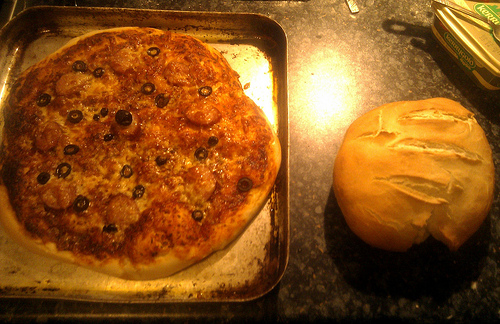

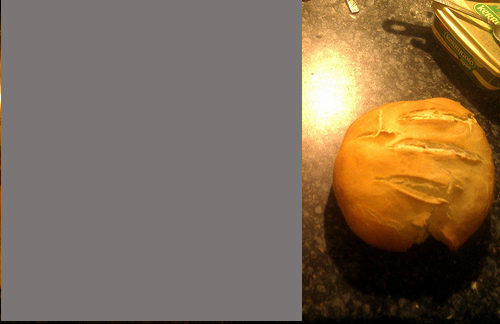

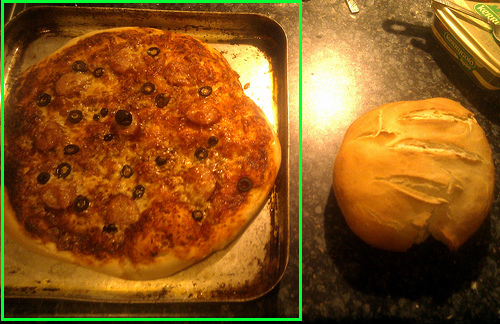

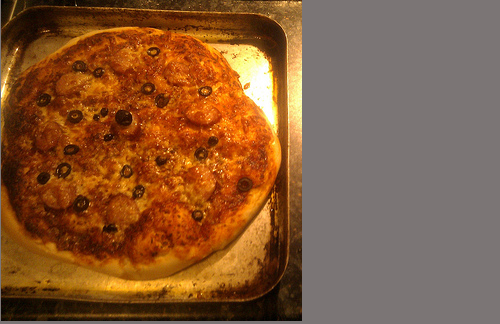

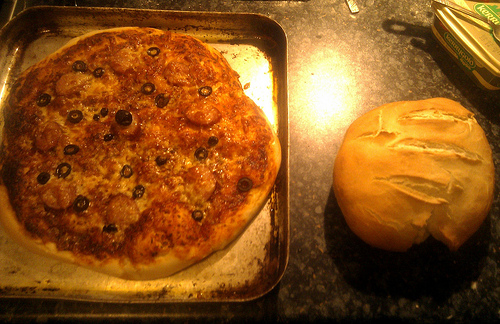

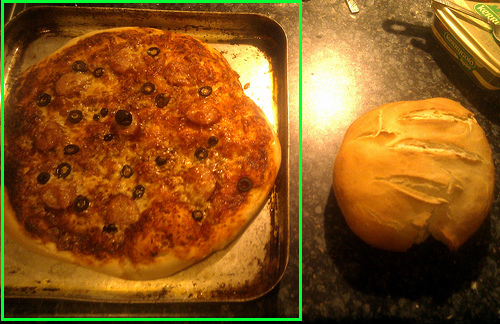

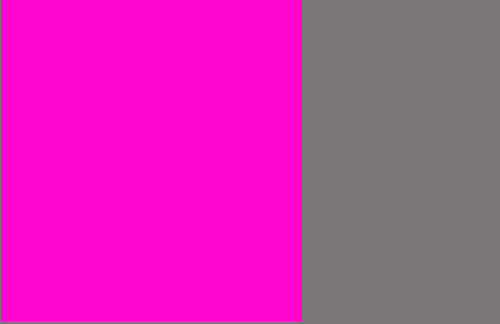

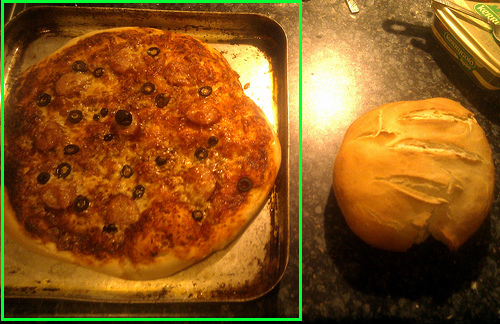

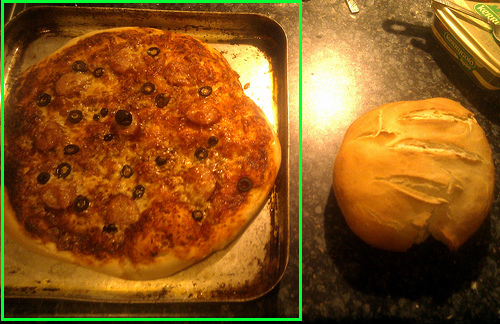

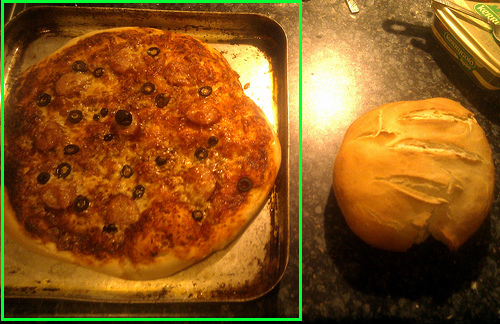

In [17]:
for i in range(10):
    display(hide_region(img, bboxes, i))

In [33]:
import copy

new_data = []
for d in data:
    bboxes = d['region']
    testid = d['test_id']
    inpcandid = testid2inpcandid[testid]
    anno = inpcandid2anno[inpcandid]
    rating = anno['annot12']
    words = d['inference'].split()
    #if 'it' in words or 'that' in words or 'this' in words:
    #    continue
    new_d = copy.deepcopy(d)
    if rating <= 1:
        new_d['label'] = 0
    elif rating >= 3:
        new_d['label'] = 1
    else:
        continue
    new_d['image_filename'] = url2filepath(d['image']['url'])
    new_data.append(new_d)

In [34]:
print(f"{len(new_data)} instances in new data")

1655 instances in new data


Inference: there was a paint spill
Label: 0


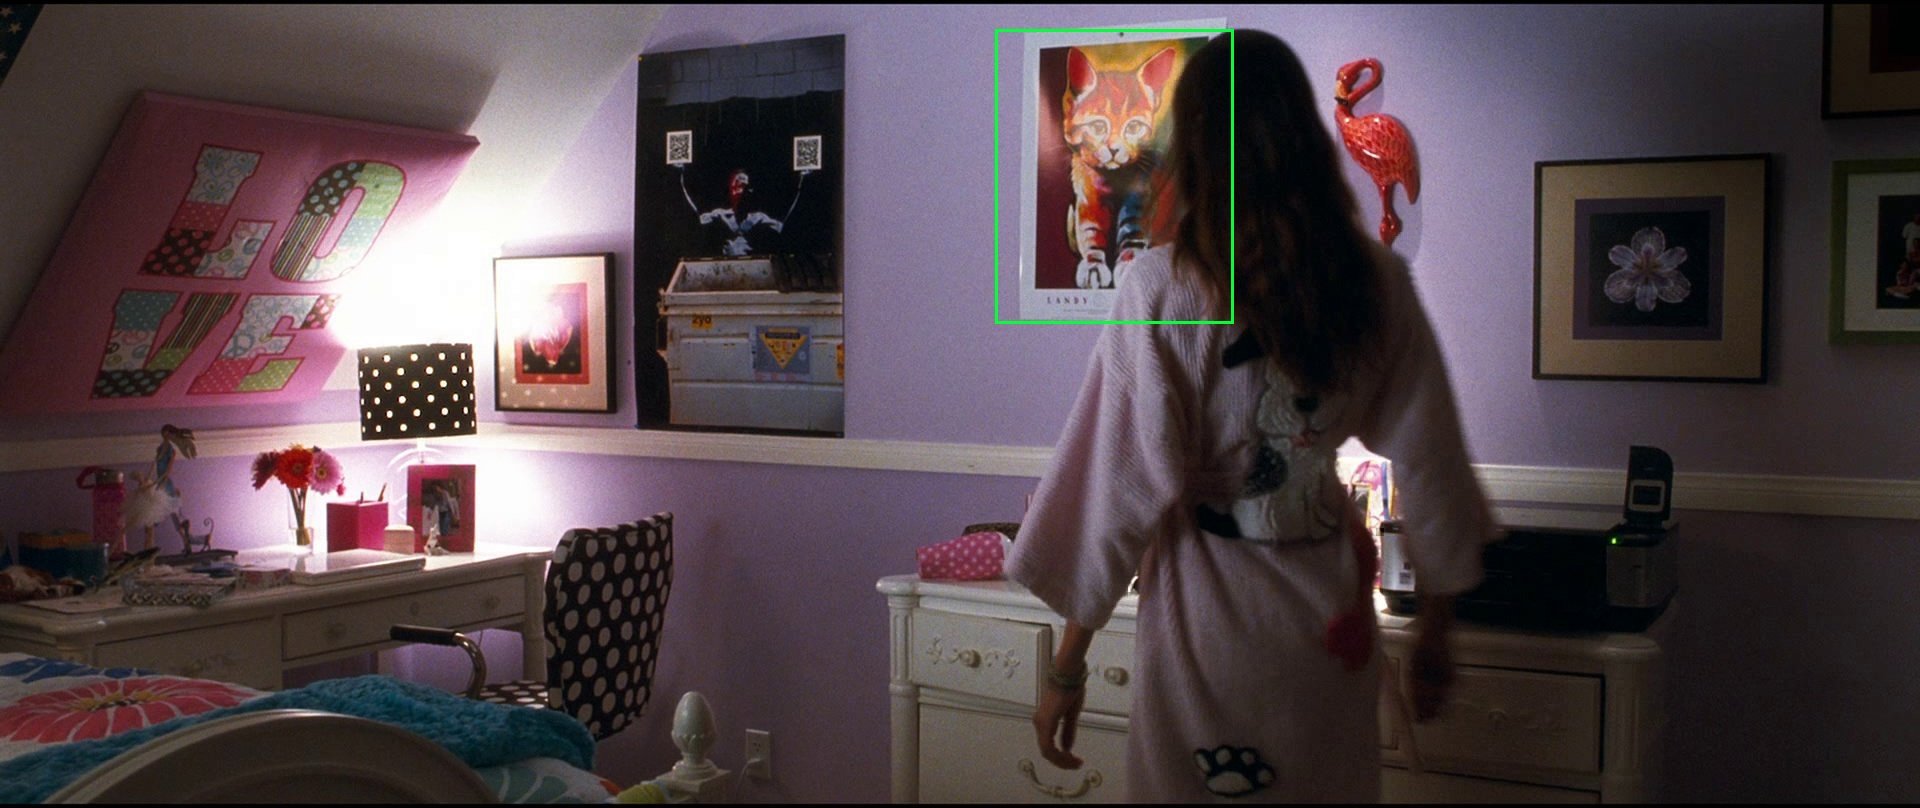

In [35]:
import random
from PIL import Image
import requests
from io import BytesIO

idx = random.randint(0, len(new_data))
d = new_data[idx]
#print(f"Clue: {d['inputs']['clue']}")
print(f"Inference: {d['inference']}")

response = requests.get(d['image']['url'])
img = Image.open(BytesIO(response.content))
#bboxes = d['inputs']['bboxes']
bboxes = d['region']

testid = d['test_id']
inpcandid = testid2inpcandid[testid]
anno = inpcandid2anno[inpcandid]
#print(f"Average human rating: {anno['annot12']}")
print(f"Label: {d['label']}")

display(hide_region(img, bboxes, 2))

In [36]:
newdata_inputids = []
for d in new_data:
    testid = d['test_id']
    inputid = testid2inpcandid[testid][0]
    d['input_id'] = inputid
    if inputid not in newdata_inputids:
        newdata_inputids.append(inputid)
print(f"{len(newdata_inputids)} unique (image, region) inputs")

457 unique (image, region) inputs


In [38]:
gtinferences = []
for d in gt_data:
    if d['instance_id'] in newdata_inputids:
        try:
            new_instance = {
                'image': d['inputs']['image'],
                'image_filename': url2filepath(d['inputs']['image']['url']), 
                'region': d['inputs']['bboxes'], 
                'inference': d['targets']['inference'], 
                'test_id': f"{d['instance_id']}_groundtruth", 
                'input_id': d['instance_id'], 
                'label': 1
            }
        except:
            import pdb; pdb.set_trace()
        gtinferences.append(new_instance)
print(f"{len(gtinferences)} new ground-truth (image, region, inference) instances")

457 new ground-truth (image, region, inference) instances


In [39]:
combined_data = new_data + gtinferences
print(f"{len(combined_data)} total instances after combining GT inferences")
print(f"{len([d for d in combined_data if d['label'] == 1])} positive instances")
print(f"{len([d for d in combined_data if d['label'] == 0])} negative instances")

2112 total instances after combining GT inferences
949 positive instances
1163 negative instances


In [40]:
calibtrain_inputids = newdata_inputids[:150]
calibeval_inputids = newdata_inputids[150:300]
eval_inputids = newdata_inputids[300:]

calibtrain_instances = [d for d in combined_data if d['input_id'] in calibtrain_inputids]
calibeval_instances = [d for d in combined_data if d['input_id'] in calibeval_inputids]
eval_instances = [d for d in combined_data if d['input_id'] in eval_inputids]

def get_instances_stats(instances):
    total_size = len(instances)
    num_pos = len([d for d in instances if d['label'] == 1])
    num_neg = len([d for d in instances if d['label'] == 0])
    return total_size, num_pos, num_neg

def balance_data(instances):
    pos_instances = [d for d in instances if d['label'] == 1]
    neg_instances = [d for d in instances if d['label'] == 0]
    random.shuffle(neg_instances)
    neg_instances = neg_instances[:len(pos_instances)]
    new_instances = pos_instances + neg_instances
    random.shuffle(new_instances)
    return new_instances

a, b, c = get_instances_stats(eval_instances)
print(f"EVAL SPLIT: {a} instances, {b} positive, {c} negative")
calibeval_instances = balance_data(calibeval_instances)
a, b, c = get_instances_stats(calibeval_instances)
print(f"CALIB-EVAL SPLIT: {a} instances, {b} positive, {c} negative")
calibtrain_instances = balance_data(calibtrain_instances)
a, b, c = get_instances_stats(calibtrain_instances)
print(f"CALIB-TRAIN SPLIT: {a} instances, {b} positive, {c} negative")

EVAL SPLIT: 561 instances, 288 positive, 273 negative
CALIB-EVAL SPLIT: 664 instances, 332 positive, 332 negative
CALIB-TRAIN SPLIT: 658 instances, 329 positive, 329 negative


In [41]:
folder = '/net/nfs.cirrascale/mosaic/tejass/data/sherlock/preprocd_data_balanced'
import os

json.dump(eval_instances, open(os.path.join(folder, 'preprocd_data_eval.json'), 'w'), indent=2)
json.dump(calibeval_instances, open(os.path.join(folder, 'preprocd_data_calibeval.json'), 'w'), indent=2)
json.dump(calibtrain_instances, open(os.path.join(folder, 'preprocd_data_calibtrain.json'), 'w'), indent=2)

In [ ]:
val_data = json.load(open('/net/nfs.cirrascale/mosaic/tejass/data/sherlock/sherlock_val_with_split_idxs_v1_1.json'))
val_data[0]

## Sherlock DirectVQA|

In [ ]:
import json 

qid2rollouts = json.load(open('/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/directvqa/sherlock/eval_outputs/instructblipflant5xl_direct_vqa-561examples.json'))
qids = list(qid2rollouts.keys())
print(len(qids))

In [ ]:
qid = random.choice(qids)
r = qid2rollouts[qid][0]
print(f"Question: {r['vqa_question']}")
print(f"Correct answer: {r['annotated_answers'][0]}")
print(f"Predicted answer: {r['answer']}")
image = Image.open(r['image_path'])
bbox = r['bbox']
#display(image)
display(hide_region(image, bboxes, 2))

In [ ]:
preds, labels = [], []
for qid in qids:
    r = qid2rollouts[qid][0]
    pred = 1 if r['answer'] == 'yes' else 0
    label = 1 if r['annotated_answers'][0] == 'yes' else 0
    preds.append(pred)
    labels.append(label)
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

print(f"{labels.count(0)} 'no' labels, {labels.count(1)} 'yes' labels")
print(f"{preds.count(0)} 'no' predictions, {preds.count(1)} 'yes' predictions")
f1 = f1_score(labels, preds, pos_label=1)#, average='macro')
print("F1 of positive class:", f1)
f1 = f1_score(labels, preds, pos_label=0)#, average='macro')
print("F1 of negative class:", f1)
acc = accuracy_score(labels, preds)
print(f"Total accuracy:", acc)
prec = precision_score(labels, preds)
print(f"Precision:", prec)
recall = recall_score(labels, preds)
print("Recall:", recall)